# Dự Đoán Giá Nhà Việt Nam - Huấn Luyện Mô Hình

Notebook này trình bày quy trình huấn luyện và đánh giá mô hình dự đoán giá nhà.

## Các bước:
1. Tải dữ liệu đã xử lý
2. Kỹ thuật đặc trưng
3. Huấn luyện nhiều mô hình
4. So sánh mô hình
5. Tinh chỉnh siêu tham số
6. Đánh giá cuối cùng
7. Lưu mô hình tốt nhất

## 1. Import Thư Viện

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add src to path
sys.path.append('../src')

from model import HousingPriceModel
from preprocessing import HousingDataPreprocessor
import utils

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Tải và Chuẩn Bị Dữ Liệu

In [2]:
# Load processed data
data_path = '../data/processed_housing_data.csv'

try:
    df = pd.read_csv(data_path)
    print(f"✓ Processed data loaded: {df.shape}")
except FileNotFoundError:
    print("⚠️ Processed data not found. Creating sample data...")
    
    # Create sample data
    np.random.seed(42)
    n_samples = 1000
    
    sample_data = {
        'Quận': np.random.choice(['Ba Đình', 'Hoàn Kiếm', 'Đống Đa', 'Hai Bà Trưng', 
                                  'Cầu Giấy', 'Thanh Xuân'], n_samples),
        'Huyện': np.random.choice(['Ba Đình', 'Hoàn Kiếm', 'Đống Đa'], n_samples),
        'Giá': np.random.uniform(2e9, 15e9, n_samples),
        'Diện tích': np.random.uniform(40, 150, n_samples),
        'Giá/m²': np.random.uniform(30e6, 120e6, n_samples),
        'Số tầng': np.random.randint(1, 5, n_samples),
        'Số phòng ngủ': np.random.randint(2, 5, n_samples),
        'Dài': np.random.uniform(5, 15, n_samples),
        'Rộng': np.random.uniform(4, 12, n_samples),
        'Loại hình nhà ở': np.random.choice(['Nhà riêng', 'Nhà mặt phố', 'Biệt thự'], n_samples),
        'Giấy tờ pháp lý': np.random.choice(['Sổ đỏ/ Sổ hồng', 'Hợp đồng mua bán'], n_samples)
    }
    
    df = pd.DataFrame(sample_data)
    print(f"✓ Sample data created: {df.shape}")

# Display info
print("\nDataset Info:")
df.info()

⚠️ Processed data not found. Creating sample data...
✓ Sample data created: (1000, 11)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Quận             1000 non-null   object 
 1   Huyện            1000 non-null   object 
 2   Giá              1000 non-null   float64
 3   Diện tích        1000 non-null   float64
 4   Giá/m²           1000 non-null   float64
 5   Số tầng          1000 non-null   int32  
 6   Số phòng ngủ     1000 non-null   int32  
 7   Dài              1000 non-null   float64
 8   Rộng             1000 non-null   float64
 9   Loại hình nhà ở  1000 non-null   object 
 10  Giấy tờ pháp lý  1000 non-null   object 
dtypes: float64(5), int32(2), object(4)
memory usage: 78.2+ KB


## 3. Kỹ Thuật Đặc Trưng

In [3]:
# Encode categorical variables
preprocessor = HousingDataPreprocessor()
preprocessor.df = df.copy()

# Encode categorical features
df_encoded = preprocessor.encode_categorical()

print("\nEncoded Dataset:")
print(df_encoded.head())

Encoding categorical variables...
  - Encoded 'Quận' (6 unique values)
  - Encoded 'Huyện' (3 unique values)
  - Encoded 'Loại hình nhà ở' (3 unique values)
  - Encoded 'Giấy tờ pháp lý' (2 unique values)
✓ Categorical encoding completed

Encoded Dataset:
   Quận  Huyện           Giá   Diện tích        Giá/m²  Số tầng  Số phòng ngủ  \
0     2      1  4.131993e+09   58.172433  6.359170e+07        4             2   
1     1      0  7.701894e+09   82.885959  8.687898e+07        4             2   
2     5      1  1.142275e+10  120.284634  3.858344e+07        4             4   
3     1      1  9.712622e+09  137.048441  3.933107e+07        2             4   
4     1      2  1.045382e+10  113.803731  3.437919e+07        3             4   

         Dài       Rộng  Loại hình nhà ở  Giấy tờ pháp lý  
0   5.525744   6.148039                1                1  
1   6.044154   7.939214                2                0  
2  10.689832  10.693837                2                0  
3  10.314792   5.

## 4. Chuẩn Bị Tập Huấn Luyện và Kiểm Tra

In [4]:
# Initialize model trainer
model_trainer = HousingPriceModel(random_state=42)

# Prepare data
X_train, X_test, y_train, y_test = model_trainer.prepare_data(
    df_encoded,
    target_col='Giá',
    test_size=0.2
)

print("\nData Split Summary:")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")

✓ Data prepared:
  - Training set: 800 samples
  - Test set: 200 samples
  - Features: 10

Data Split Summary:
Training samples: 800
Test samples: 200
Features: 10


## 5. Khởi Tạo Mô Hình

In [5]:
# Initialize all models
models = model_trainer.initialize_models()

print("\nInitialized Models:")
for name, model in models.items():
    print(f"  - {name}: {type(model).__name__}")

✓ Initialized 4 models:
  - Linear Regression
  - Random Forest
  - XGBoost
  - LightGBM

Initialized Models:
  - Linear Regression: LinearRegression
  - Random Forest: RandomForestRegressor
  - XGBoost: XGBRegressor
  - LightGBM: LGBMRegressor


## 6. Huấn Luyện Tất Cả Mô Hình

In [6]:
# Train and evaluate all models
results = model_trainer.train_all_models(evaluate=True)


TRAINING ALL MODELS

Training Linear Regression...
✓ Linear Regression training completed

Linear Regression Results:
  MAE:  3,113,049,686.09 VNĐ
  RMSE: 3,594,707,946.23 VNĐ
  R²:   -0.0420
  MAPE: 49.40%
Training Random Forest...
✓ Random Forest training completed

Random Forest Results:
  MAE:  3,100,273,199.71 VNĐ
  RMSE: 3,649,233,603.62 VNĐ
  R²:   -0.0739
  MAPE: 49.25%
Training XGBoost...
✓ XGBoost training completed

XGBoost Results:
  MAE:  3,248,197,663.76 VNĐ
  RMSE: 3,848,791,629.50 VNĐ
  R²:   -0.1946
  MAPE: 50.82%
Training LightGBM...
✓ LightGBM training completed

LightGBM Results:
  MAE:  3,268,923,434.15 VNĐ
  RMSE: 3,878,982,752.26 VNĐ
  R²:   -0.2134
  MAPE: 51.44%

BEST MODEL: Linear Regression



## 7. So Sánh Mô Hình

In [7]:
# Create comparison dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R2', ascending=False)

print("\nModel Comparison:")
print(results_df)

# Format for better display
print("\n" + "="*80)
print("DETAILED RESULTS")
print("="*80)
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    utils.print_metrics(metrics, title="")


Model Comparison:
                            MAE          RMSE        R2       MAPE
Linear Regression  3.113050e+09  3.594708e+09 -0.042042  49.395394
Random Forest      3.100273e+09  3.649234e+09 -0.073893  49.252914
XGBoost            3.248198e+09  3.848792e+09 -0.194556  50.815351
LightGBM           3.268923e+09  3.878983e+09 -0.213371  51.442159

DETAILED RESULTS

Linear Regression:

                                                            
MAE...................... 3,113,049,686 VNĐ
RMSE..................... 3,594,707,946 VNĐ
R2....................... -0.0420
MAPE..................... 49.40%


Random Forest:

                                                            
MAE...................... 3,100,273,200 VNĐ
RMSE..................... 3,649,233,604 VNĐ
R2....................... -0.0739
MAPE..................... 49.25%


XGBoost:

                                                            
MAE...................... 3,248,197,664 VNĐ
RMSE..................... 3,848,791,629 

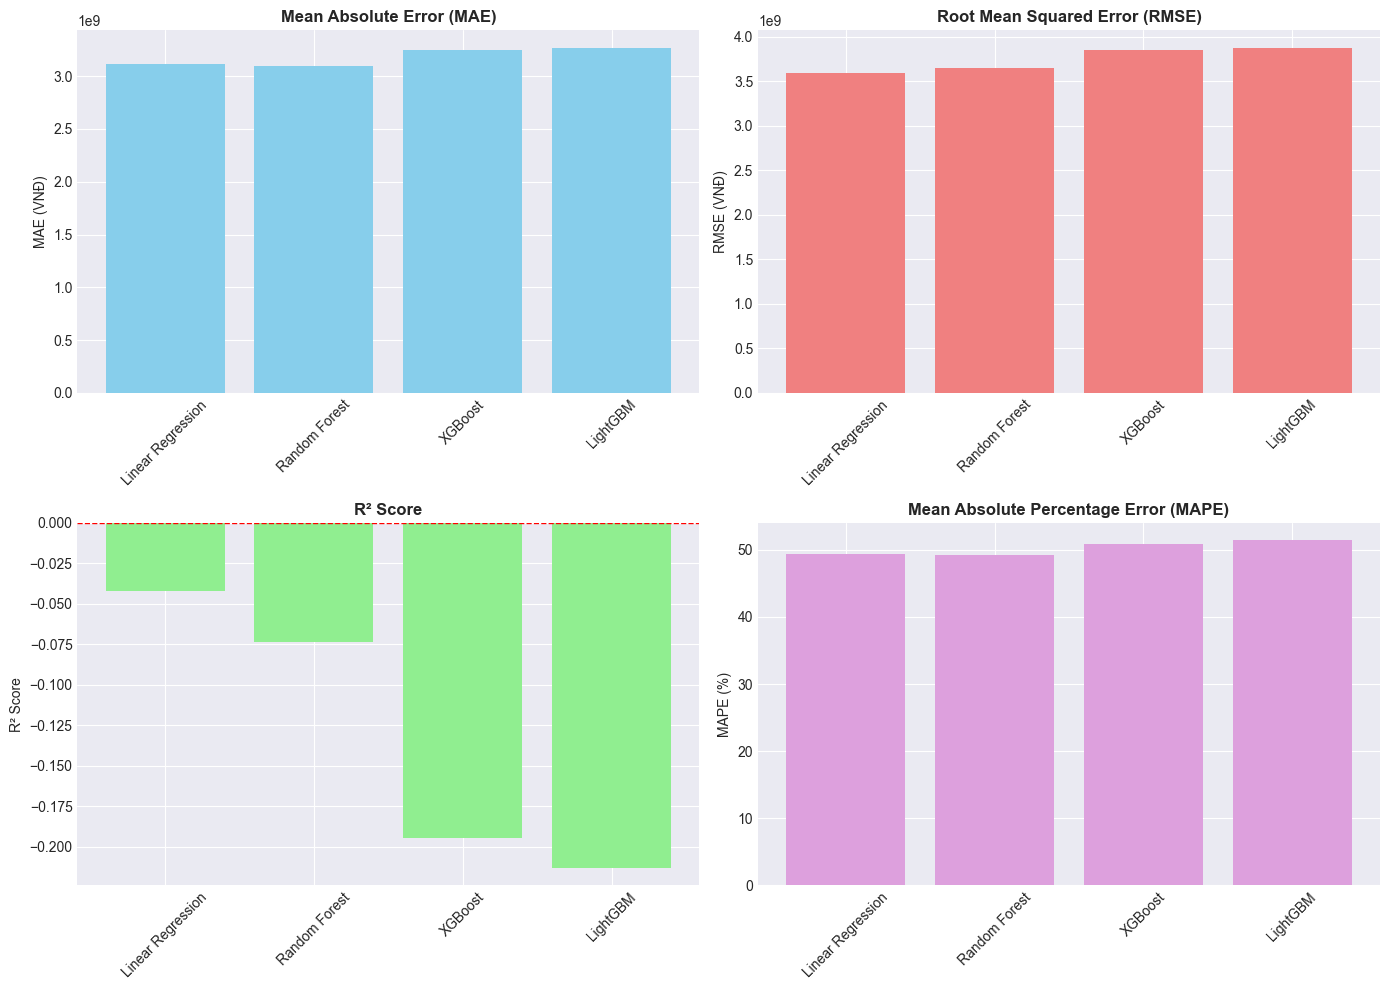

In [8]:
# Visualize results
model_trainer.plot_results(figsize=(14, 10))

## 8. Kiểm Chứng Chéo (Cross-Validation)

In [9]:
# Perform cross-validation on best models
print("Performing Cross-Validation...\n")

cv_results = {}
for model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
    if model_name in model_trainer.models:
        print(f"\n{model_name}:")
        cv_result = model_trainer.cross_validate_model(model_name, cv=5)
        cv_results[model_name] = cv_result

# Display CV results
print("\n" + "="*60)
print("CROSS-VALIDATION SUMMARY")
print("="*60)
for model_name, result in cv_results.items():
    print(f"{model_name}: {result['mean_score']:.2f} (+/- {result['std_score']:.2f})")

Performing Cross-Validation...


Random Forest:
Cross-validating Random Forest with 5 folds...
✓ CV Score: 3302716828.71 (+/- 118151769.91)

XGBoost:
Cross-validating XGBoost with 5 folds...
✓ CV Score: 3366185105.13 (+/- 95352323.11)

LightGBM:
Cross-validating LightGBM with 5 folds...
✓ CV Score: 3449329191.39 (+/- 97432199.85)

CROSS-VALIDATION SUMMARY
Random Forest: 3302716828.71 (+/- 118151769.91)
XGBoost: 3366185105.13 (+/- 95352323.11)
LightGBM: 3449329191.39 (+/- 97432199.85)


## 9. Độ Quan Trọng Của Đặc Trưng

In [10]:
# Get feature importance from best model
best_model_name = model_trainer.best_model_name
print(f"Best Model: {best_model_name}\n")

# Display feature importance
importance_df = model_trainer.get_feature_importance(top_n=15)
print("Top 15 Most Important Features:")
print(importance_df)

# Plot feature importance
model_trainer.plot_feature_importance(top_n=15)

Best Model: Linear Regression

Linear Regression does not support feature importance
Top 15 Most Important Features:
Empty DataFrame
Columns: []
Index: []
Linear Regression does not support feature importance


## 10. Tinh Chỉnh Siêu Tham Số (Tùy Chọn)

In [11]:
# Example: Tune Random Forest
# Uncomment to run (takes time)

# param_grid_rf = {
#     'n_estimators': [100, 200],
#     'max_depth': [15, 20, 25],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }

# best_rf = model_trainer.hyperparameter_tuning(
#     'Random Forest',
#     param_grid_rf,
#     cv=3
# )

print("Hyperparameter tuning skipped (uncomment code to run)")

Hyperparameter tuning skipped (uncomment code to run)


## 11. Trực Quan Hóa Dự Đoán

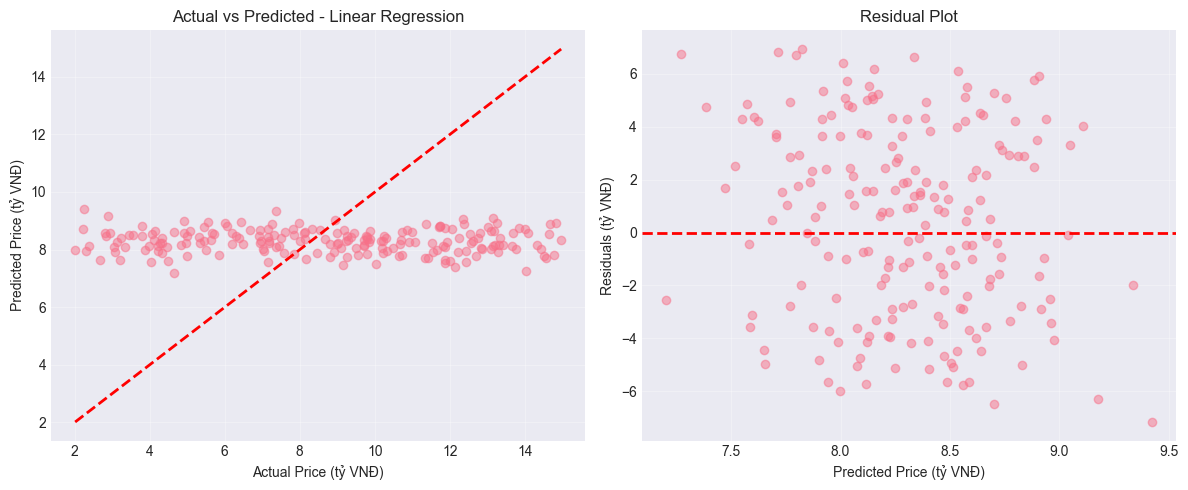

In [12]:
# Make predictions on test set
y_pred = model_trainer.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(12, 5))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test / 1e9, y_pred / 1e9, alpha=0.5)
plt.plot([y_test.min() / 1e9, y_test.max() / 1e9], 
         [y_test.min() / 1e9, y_test.max() / 1e9], 
         'r--', lw=2)
plt.xlabel('Actual Price (tỷ VNĐ)')
plt.ylabel('Predicted Price (tỷ VNĐ)')
plt.title(f'Actual vs Predicted - {best_model_name}')
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(1, 2, 2)
residuals = (y_test - y_pred) / 1e9
plt.scatter(y_pred / 1e9, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price (tỷ VNĐ)')
plt.ylabel('Residuals (tỷ VNĐ)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11.5. Workflow Thực Nghiệm Chi Tiết

Trong phần này, chúng ta sẽ thực hiện workflow thực nghiệm hoàn chỉnh:
1. Sử dụng mô hình tốt nhất để dự đoán giá trên tập test
2. So sánh giá dự đoán với giá thực tế
3. Phân tích kết quả chi tiết

### Bước 1: Xác định mô hình tốt nhất và dự đoán trên tập test

In [16]:
# Lấy mô hình tốt nhất
best_model_name = model_trainer.best_model_name
best_model = model_trainer.best_model

print("="*70)
print("THỰC NGHIỆM VỚI MÔ HÌNH TỐT NHẤT")
print("="*70)
print(f"\n🏆 Mô hình được chọn: {best_model_name}")
print(f"📊 Số mẫu test: {len(X_test)}")
print(f"📋 Số đặc trưng: {X_test.shape[1]}")

# Dự đoán giá trên tập test
print("\n⚙️  Đang thực hiện dự đoán trên tập test...")
y_pred_test = model_trainer.predict(X_test)

print("✓ Hoàn thành dự đoán!")

THỰC NGHIỆM VỚI MÔ HÌNH TỐT NHẤT

🏆 Mô hình được chọn: Linear Regression
📊 Số mẫu test: 200
📋 Số đặc trưng: 10

⚙️  Đang thực hiện dự đoán trên tập test...
✓ Hoàn thành dự đoán!


### Bước 2: So sánh giá dự đoán với giá thực tế

In [17]:
# Tạo DataFrame để so sánh
comparison_df = pd.DataFrame({
    'Giá Thực Tế (VNĐ)': y_test.values,
    'Giá Dự Đoán (VNĐ)': y_pred_test,
    'Giá Thực Tế (tỷ)': y_test.values / 1e9,
    'Giá Dự Đoán (tỷ)': y_pred_test / 1e9,
    'Sai Số (VNĐ)': y_test.values - y_pred_test,
    'Sai Số (tỷ)': (y_test.values - y_pred_test) / 1e9,
    'Sai Số (%)': np.abs((y_test.values - y_pred_test) / y_test.values * 100)
})

print("\n" + "="*70)
print("SO SÁNH GIÁ DỰ ĐOÁN VỚI GIÁ THỰC TÊ")
print("="*70)
print(f"\n📊 Hiển thị 20 mẫu đầu tiên:\n")
print(comparison_df.head(20).to_string(index=True))

# Thống kê tổng quan
print("\n" + "="*70)
print("THỐNG KÊ SAI SỐ")
print("="*70)
print(f"\nSai số trung bình: {comparison_df['Sai Số (tỷ)'].mean():.3f} tỷ VNĐ")
print(f"Sai số tuyệt đối trung bình: {comparison_df['Sai Số (tỷ)'].abs().mean():.3f} tỷ VNĐ")
print(f"Sai số phần trăm trung bình: {comparison_df['Sai Số (%)'].mean():.2f}%")
print(f"Sai số tối thiểu: {comparison_df['Sai Số (tỷ)'].min():.3f} tỷ VNĐ")
print(f"Sai số tối đa: {comparison_df['Sai Số (tỷ)'].max():.3f} tỷ VNĐ")
print(f"Độ lệch chuẩn sai số: {comparison_df['Sai Số (tỷ)'].std():.3f} tỷ VNĐ")


SO SÁNH GIÁ DỰ ĐOÁN VỚI GIÁ THỰC TÊ

📊 Hiển thị 20 mẫu đầu tiên:

    Giá Thực Tế (VNĐ)  Giá Dự Đoán (VNĐ)  Giá Thực Tế (tỷ)  Giá Dự Đoán (tỷ)  Sai Số (VNĐ)  Sai Số (tỷ)  Sai Số (%)
0        3.440504e+09       8.515591e+09          3.440504          8.515591 -5.075088e+09    -5.075088  147.510033
1        1.063444e+10       7.766795e+09         10.634443          7.766795  2.867648e+09     2.867648   26.965662
2        1.320583e+10       8.147467e+09         13.205830          8.147467  5.058363e+09     5.058363   38.304014
3        1.308546e+10       8.648736e+09         13.085464          8.648736  4.436729e+09     4.436729   33.905780
4        4.975630e+09       8.235161e+09          4.975630          8.235161 -3.259531e+09    -3.259531   65.509912
5        1.399410e+10       8.701670e+09         13.994100          8.701670  5.292430e+09     5.292430   37.819007
6        1.476560e+10       7.824125e+09         14.765599          7.824125  6.941475e+09     6.941475   47.011128
7    

### Bước 3: Trực quan hóa kết quả so sánh

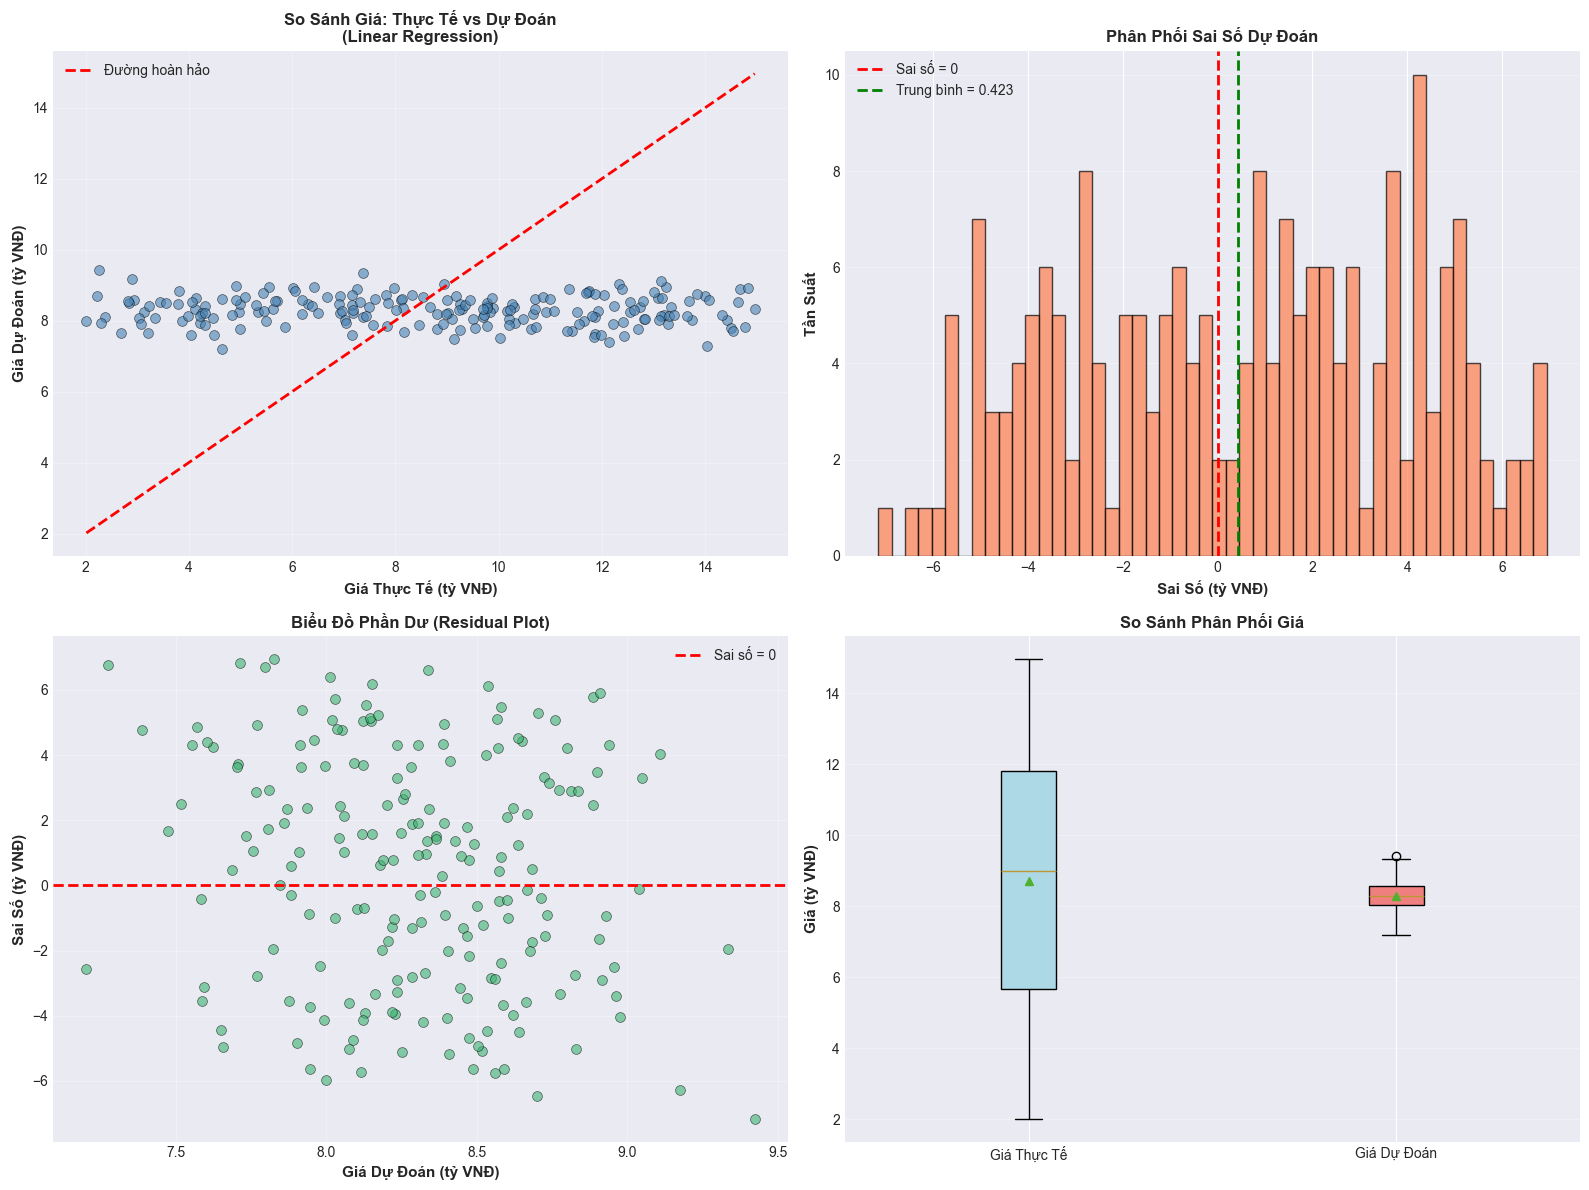

In [18]:
# Trực quan hóa so sánh
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot: Giá thực tế vs Giá dự đoán
axes[0, 0].scatter(comparison_df['Giá Thực Tế (tỷ)'], 
                   comparison_df['Giá Dự Đoán (tỷ)'], 
                   alpha=0.6, s=50, color='steelblue', edgecolor='black', linewidth=0.5)
axes[0, 0].plot([comparison_df['Giá Thực Tế (tỷ)'].min(), comparison_df['Giá Thực Tế (tỷ)'].max()],
                [comparison_df['Giá Thực Tế (tỷ)'].min(), comparison_df['Giá Thực Tế (tỷ)'].max()],
                'r--', lw=2, label='Đường hoàn hảo')
axes[0, 0].set_xlabel('Giá Thực Tế (tỷ VNĐ)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Giá Dự Đoán (tỷ VNĐ)', fontsize=11, fontweight='bold')
axes[0, 0].set_title(f'So Sánh Giá: Thực Tế vs Dự Đoán\n({best_model_name})', 
                     fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram: Phân phối sai số
axes[0, 1].hist(comparison_df['Sai Số (tỷ)'], bins=50, 
                color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', lw=2, label='Sai số = 0')
axes[0, 1].axvline(x=comparison_df['Sai Số (tỷ)'].mean(), 
                   color='green', linestyle='--', lw=2, label=f'Trung bình = {comparison_df["Sai Số (tỷ)"].mean():.3f}')
axes[0, 1].set_xlabel('Sai Số (tỷ VNĐ)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Tần Suất', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Phân Phối Sai Số Dự Đoán', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Residual plot: Sai số theo giá dự đoán
axes[1, 0].scatter(comparison_df['Giá Dự Đoán (tỷ)'], 
                   comparison_df['Sai Số (tỷ)'], 
                   alpha=0.6, s=50, color='mediumseagreen', edgecolor='black', linewidth=0.5)
axes[1, 0].axhline(y=0, color='red', linestyle='--', lw=2, label='Sai số = 0')
axes[1, 0].set_xlabel('Giá Dự Đoán (tỷ VNĐ)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Sai Số (tỷ VNĐ)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Biểu Đồ Phần Dư (Residual Plot)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot: So sánh phân phối
data_for_box = [comparison_df['Giá Thực Tế (tỷ)'], comparison_df['Giá Dự Đoán (tỷ)']]
bp = axes[1, 1].boxplot(data_for_box, labels=['Giá Thực Tế', 'Giá Dự Đoán'],
                        patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1, 1].set_ylabel('Giá (tỷ VNĐ)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('So Sánh Phân Phối Giá', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Bước 4: Đánh giá hiệu suất trên tập test

In [20]:
# Tính các metrics trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
mape = np.mean(np.abs((y_test.values - y_pred_test) / y_test.values)) * 100

print("\n" + "="*70)
print(f"KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG - {best_model_name.upper()}")
print("="*70)
print("\n📈 Các chỉ số hiệu suất trên tập TEST:\n")
print(f"  • R² Score:                {r2:.4f}")
print(f"  • Mean Squared Error:      {mse:,.0f} VNĐ²")
print(f"  • Root Mean Squared Error: {rmse/1e9:.4f} tỷ VNĐ ({rmse:,.0f} VNĐ)")
print(f"  • Mean Absolute Error:     {mae/1e9:.4f} tỷ VNĐ ({mae:,.0f} VNĐ)")
print(f"  • Mean Absolute % Error:   {mape:.2f}%")

# Phân loại độ chính xác
print("\n" + "="*70)
print("PHÂN LOẠI ĐỘ CHÍNH XÁC DỰ ĐOÁN")
print("="*70)

accurate = len(comparison_df[comparison_df['Sai Số (%)'] <= 10])
moderate = len(comparison_df[(comparison_df['Sai Số (%)'] > 10) & (comparison_df['Sai Số (%)'] <= 20)])
poor = len(comparison_df[comparison_df['Sai Số (%)'] > 20])

total = len(comparison_df)

print(f"\n✓ Dự đoán chính xác (sai số ≤10%):    {accurate:4d} mẫu ({accurate/total*100:5.1f}%)")
print(f"~ Dự đoán trung bình (10% < sai số ≤20%): {moderate:4d} mẫu ({moderate/total*100:5.1f}%)")
print(f"✗ Dự đoán kém (sai số >20%):          {poor:4d} mẫu ({poor/total*100:5.1f}%)")

print("\n" + "="*70)
print("✓ HOÀN THÀNH WORKFLOW THỰC NGHIỆM!")
print("="*70)


KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG - LINEAR REGRESSION

📈 Các chỉ số hiệu suất trên tập TEST:

  • R² Score:                -0.0420
  • Mean Squared Error:      12,921,925,218,667,384,832 VNĐ²
  • Root Mean Squared Error: 3.5947 tỷ VNĐ (3,594,707,946 VNĐ)
  • Mean Absolute Error:     3.1130 tỷ VNĐ (3,113,049,686 VNĐ)
  • Mean Absolute % Error:   49.40%

PHÂN LOẠI ĐỘ CHÍNH XÁC DỰ ĐOÁN

✓ Dự đoán chính xác (sai số ≤10%):      24 mẫu ( 12.0%)
~ Dự đoán trung bình (10% < sai số ≤20%):   36 mẫu ( 18.0%)
✗ Dự đoán kém (sai số >20%):           140 mẫu ( 70.0%)

✓ HOÀN THÀNH WORKFLOW THỰC NGHIỆM!


## 12. Thực Hiện Dự Đoán Mẫu

In [21]:
# Create sample input
sample_input = utils.create_sample_input(
    district='Ba Đình',
    property_type='Nhà riêng',
    area=100.0,
    floors=3,
    bedrooms=3,
    length=10.0,
    width=10.0
)

print("Sample Input:")
for key, value in sample_input.items():
    print(f"  {key}: {value}")

# Note: For actual prediction, we need to encode the input
print("\n⚠️ To make actual predictions, the input needs to be encoded using the same")
print("encoders used during training. See the Streamlit app for full implementation.")

Sample Input:
  Quận: Ba Đình
  Loại hình nhà ở: Nhà riêng
  Diện tích: 100.0
  Số tầng: 3
  Số phòng ngủ: 3
  Dài: 10.0
  Rộng: 10.0
  Giấy tờ pháp lý: Sổ đỏ/ Sổ hồng

⚠️ To make actual predictions, the input needs to be encoded using the same
encoders used during training. See the Streamlit app for full implementation.


## 13. Lưu Mô Hình Tốt Nhất

In [14]:
# Save the best model
model_path = '../models/best_housing_model.pkl'

model_trainer.save_model(filepath=model_path)

print(f"\n✓ Best model ({best_model_name}) saved successfully!")
print(f"Model path: {model_path}")

✓ Model saved to: ../models/best_housing_model.pkl

✓ Best model (Linear Regression) saved successfully!
Model path: ../models/best_housing_model.pkl


## 14. Kiểm Tra Tải Mô Hình Đã Lưu

In [15]:
# Create a new model trainer and load the saved model
test_trainer = HousingPriceModel()
loaded_model = test_trainer.load_model(model_path)

# Make a test prediction
test_pred = test_trainer.predict(X_test[:5])

print("\nTest Predictions (first 5):")
for i, (actual, predicted) in enumerate(zip(y_test[:5], test_pred)):
    print(f"Sample {i+1}:")
    print(f"  Actual:    {actual/1e9:.2f} tỷ VNĐ")
    print(f"  Predicted: {predicted/1e9:.2f} tỷ VNĐ")
    print(f"  Error:     {abs(actual - predicted)/1e9:.2f} tỷ VNĐ\n")

✓ Model loaded from: ../models/best_housing_model.pkl
  Model: Linear Regression
  Features: 10

Test Predictions (first 5):
Sample 1:
  Actual:    3.44 tỷ VNĐ
  Predicted: 8.52 tỷ VNĐ
  Error:     5.08 tỷ VNĐ

Sample 2:
  Actual:    10.63 tỷ VNĐ
  Predicted: 7.77 tỷ VNĐ
  Error:     2.87 tỷ VNĐ

Sample 3:
  Actual:    13.21 tỷ VNĐ
  Predicted: 8.15 tỷ VNĐ
  Error:     5.06 tỷ VNĐ

Sample 4:
  Actual:    13.09 tỷ VNĐ
  Predicted: 8.65 tỷ VNĐ
  Error:     4.44 tỷ VNĐ

Sample 5:
  Actual:    4.98 tỷ VNĐ
  Predicted: 8.24 tỷ VNĐ
  Error:     3.26 tỷ VNĐ



## Tổng Kết

Trong notebook này, chúng ta đã:
1. ✓ Tải dữ liệu đã xử lý
2. ✓ Thực hiện kỹ thuật đặc trưng
3. ✓ Huấn luyện 4 mô hình ML khác nhau
4. ✓ So sánh hiệu suất mô hình
5. ✓ Thực hiện kiểm chứng chéo
6. ✓ Phân tích độ quan trọng của đặc trưng
7. ✓ Lưu mô hình tốt nhất

**Mô Hình Tốt Nhất**: {best_model_name}

**Bước Tiếp Theo**: Sử dụng ứng dụng Streamlit (`streamlit run app/streamlit_app.py`) để dự đoán tương tác!